## Plot results

1000
1000


2006-02-08 to 2010-01-28                     2010-01-29 to 2014-01-17  \
                             CR        SR        MD                       CR   
base                1481.741952  0.242634  0.217876               236.010402   
market                 1.679952  0.037649  0.487445                 2.359294   

                            
              SR        MD  
base    0.200974  0.220313  
market  0.079882  0.184375

250
250


2014-01-21 to 2015-01-15                     2015-01-16 to 2016-01-13  \
                             CR        SR        MD                       CR   
base                   1.218643  0.071210  0.134430                 1.401181   
market                 1.119521  0.053813  0.104463                 1.236619   

                            
              SR        MD  
base    0.088352  0.140602  
market  0.076438  0.130071

383
383
1


2016-01-14 to 2017-07-21                     2017-07-24 to 2019-01-30  \
                             CR        SR        MD                       CR   
base                   1.882903  0.161184  0.148632                 1.508365   
market                 1.480489  0.120713  0.084195                 1.344739   

                            
              SR        MD  
base    0.072643  0.239422  
market  0.064084  0.208080

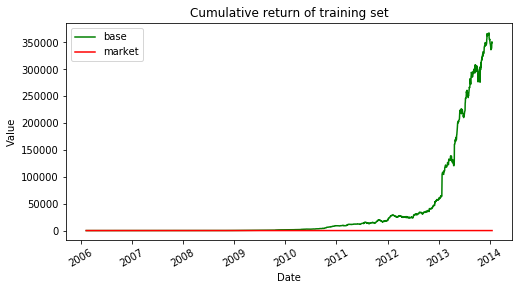

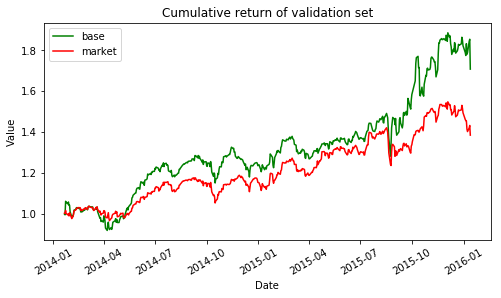

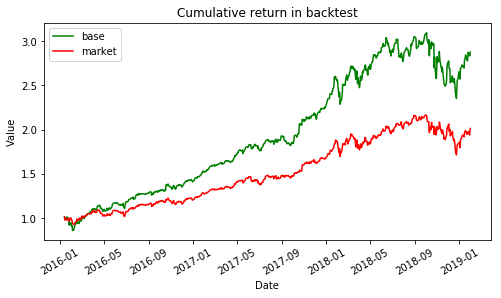

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from dataset import StockData
data = StockData('data.csv', features=['Open', 'High', 'Low', 'Close'])

# ret is 1d or 2d numpy array, Series or DataFrame
def cr(ret):
    '''cumulative return'''
    ret = (ret+1).cumprod(axis=0)
    return ret.iloc[-1]

def sharpe(ret):
    '''sharpe ratio'''
    return ret.mean(axis=0)/ret.std(axis=0) # std=0, almost impossible

def mdd(ret):
    '''maximum drawdown'''
    ret = (ret+1).cumprod(axis=0)
    return np.max(1 - ret/np.maximum.accumulate(ret, axis=0), axis=0)

def measure(ret, sections=2):
    step = len(ret)//sections
    dfs = []
    keys = []
    for s in range(0, len(ret), step):
        e = s + step
        sec = ret.iloc[s:e]
        l = len(sec)
        print(l)
        if l < step:
            break
        tmp = {}
        tmp['CR'] = cr(sec)
        tmp['SR'] = sharpe(sec)
        tmp['MD'] = mdd(sec)
        df = pd.DataFrame(tmp)
        dfs.append(df)
        keys.append('{:%Y-%m-%d} to {:%Y-%m-%d}'.format(sec.index[0],sec.index[-1]))
    display(pd.concat(dfs, axis=1, keys=keys))

def plot(df, title=''):
    df += .0005
    start = df.index[0]
    end = df.index[-1] + 1
    market = data.UBAH(start, end)
    df.index=market.index # set index first
    df['market'] = market

    measure(df, 2)

    df = (df+1).cumprod(axis=0)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_title(title)
#     ax1.set_yscale('log')
    ax.set_title(title)
    for c in df.columns:
        if 'base' in c:
            color = 'green'
        elif 'market' in c:
            color = 'red'
        else:
            color = None
        ax.plot(df[c], color=color)
    ax.legend()
    return fig

def expand_dir(save_dir):
    sub_dirs = next(os.walk(save_dir))[1]
    if sub_dirs:
        return [save_dir.joinpath(sub) for sub in sub_dirs]
    else:
        return [save_dir]

def compare_with_base(save_dir, base_name='base'):
    test = {}
    save_dirs = expand_dir(Path(save_dir))
    save_dirs.append(Path('exp/base'))
    for save_dir in save_dirs:
        name = os.path.basename(save_dir)
        test[name] = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col=0)['ret']
        # todo: borrow 250 examples from validation set in order to add up to 1000 backtest examples
        valid = pd.read_csv(save_dir.joinpath('valid_best_epoch.csv'), index_col=0)['ret']
        test[name] = pd.concat([valid[-250:], test[name]])
        assert len(test[name]>1000)
    test[base_name] = test.pop('base')
    df  = pd.DataFrame(test)
    df = df.iloc[:1000]
    fig3 = plot(df, 'Cumulative return in backtest')


save_dir = Path('exp/base')

train = {}
valid = {}
test = {}
save_dirs = expand_dir(save_dir)
for save_dir in save_dirs:
    name = os.path.basename(save_dir)
    train[name] = pd.read_csv(save_dir.joinpath('train_last_epoch.csv'), index_col=0)['ret']
    valid[name] = pd.read_csv(save_dir.joinpath('valid_best_epoch.csv'), index_col=0)['ret']
    test[name] = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col=0)['ret']
fig1 = plot(pd.DataFrame(train), 'Cumulative return of training set')
fig2 = plot(pd.DataFrame(valid), 'Cumulative return of validation set')
fig3 = plot(pd.DataFrame(test), 'Cumulative return in backtest')


### network

500
500


2015-01-16 to 2017-01-10                      \
                                CR        SR        MD   
RNN                       1.909072  0.086109  0.269243   
LSTM                      1.775068  0.080409  0.293800   
CNN(base)                 2.039002  0.104007  0.219720   
market                    1.526463  0.082403  0.167820   

          2017-01-11 to 2019-01-07                      
                                CR        SR        MD  
RNN                       1.586760  0.066988  0.329927  
LSTM                      1.607684  0.066520  0.304962  
CNN(base)                 1.858812  0.091158  0.239422  
market                    1.543761  0.078051  0.208080

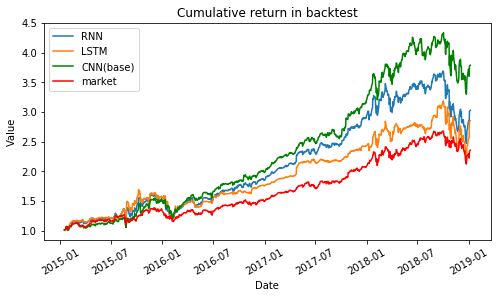

In [2]:
compare_with_base('exp/network', 'CNN(base)')

### output

500
500


2015-01-16 to 2017-01-10                      \
                                    CR        SR        MD   
tanh                          2.170140  0.145810  0.145337   
sigmoid                       2.052005  0.143861  0.116603   
softmax(base)                 2.039002  0.104007  0.219720   
market                        1.526463  0.082403  0.167820   

              2017-01-11 to 2019-01-07                      
                                    CR        SR        MD  
tanh                          2.019525  0.122849  0.187679  
sigmoid                       1.923896  0.119746  0.186612  
softmax(base)                 1.858812  0.091158  0.239422  
market                        1.543761  0.078051  0.208080

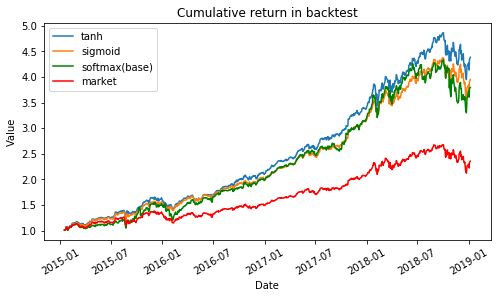

In [3]:
compare_with_base('exp/output', 'softmax(base)')

### online

500
500


2015-01-16 to 2017-01-10                     2017-01-11 to 2019-01-07  \
                             CR        SR        MD                       CR   
online                 2.146081  0.109544  0.212753                 1.917589   
base                   2.039002  0.104007  0.219720                 1.858812   
market                 1.526463  0.082403  0.167820                 1.543761   

                            
              SR        MD  
online  0.102424  0.216840  
base    0.091158  0.239422  
market  0.078051  0.208080

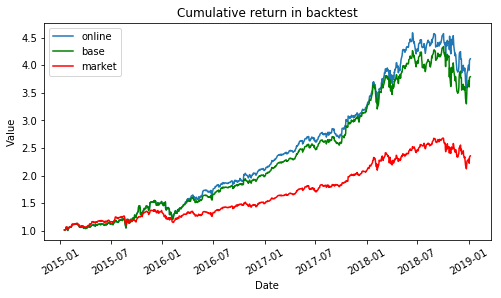

In [4]:
compare_with_base('exp/online')

### features

500
500


2015-01-16 to 2017-01-10                     \
                                 CR        SR       MD   
features                   2.668219  0.111808  0.26420   
OHLC(base)                 2.039002  0.104007  0.21972   
market                     1.526463  0.082403  0.16782   

           2017-01-11 to 2019-01-07                      
                                 CR        SR        MD  
features                   1.812169  0.089674  0.232074  
OHLC(base)                 1.858812  0.091158  0.239422  
market                     1.543761  0.078051  0.208080

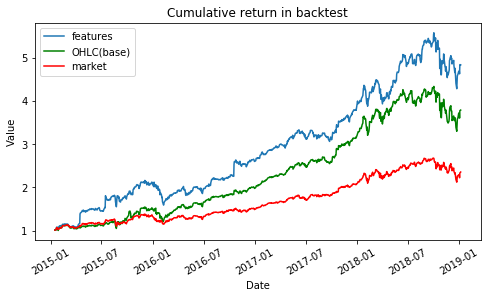

In [5]:
compare_with_base('exp/features', 'OHLC(base)')

### loss

500
500


2015-01-16 to 2017-01-10                      \
                                   CR        SR        MD   
binary                       2.013946  0.148192  0.111160   
multiclass                   2.117552  0.095933  0.327207   
return(base)                 2.039002  0.104007  0.219720   
market                       1.526463  0.082403  0.167820   

             2017-01-11 to 2019-01-07                      
                                   CR        SR        MD  
binary                       1.890949  0.126187  0.167812  
multiclass                   2.041946  0.096875  0.287806  
return(base)                 1.858812  0.091158  0.239422  
market                       1.543761  0.078051  0.208080

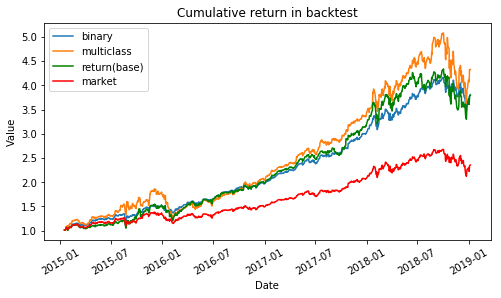

In [6]:
compare_with_base('exp/loss', 'return(base)')

### window

500
500


2015-01-16 to 2017-01-10                     2017-01-11 to 2019-01-07  \
                              CR        SR        MD                       CR   
10                      1.827555  0.096309  0.207925                 2.176207   
15                      2.260525  0.131153  0.203797                 1.970276   
5(base)                 2.039002  0.104007  0.219720                 1.858812   
market                  1.526463  0.082403  0.167820                 1.543761   

                             
               SR        MD  
10       0.128123  0.193029  
15       0.105357  0.249968  
5(base)  0.091158  0.239422  
market   0.078051  0.208080

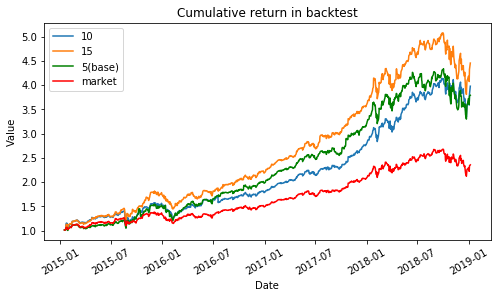

In [7]:
compare_with_base('exp/hyperparameters/window', '5(base)')

## Case Study
It's necessary to investigate the prediction on a single training/testing point because huge negative return is produced on some days.

### findings

1. output similar to one-hot encoding which means only one stock is held at a time
2. some stocks are much more likely to be chosen
3. a stock with downtrend is still chosen

Training   from 2006-02-08 to 2014-01-17
Validation from 2014-01-21 to 2016-01-13
Test       from 2016-01-14 to 2019-01-31
data_path: data.csv
features: ['Open', 'High', 'Low', 'Close']
stocks: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'INTC', 'CSCO', 'CMCSA', 'PEP', 'NFLX', 'ADBE']
epoch: 100
window: 5
learning_rate: 0.001
train_batch_num: 200
train_batch_size: 10
valid_batch_num: 1
valid_batch_size: 500
test_batch_num: None
test_batch_size: 1
online_train: False
online_train_batch_num: 10
p: 0.01
Net: functools.partial(<class 'model.CNN_T'>, T=25)
f: <_io.TextIOWrapper name='exp/base/config.py' mode='r' encoding='UTF-8'>
data: <dataset.StockData_DR object at 0x1256fcac8>
net: CNN_T(
  (conv1): Conv2d(4, 128, kernel_size=(1, 3), stride=(1, 1), bias=False)
  (conv2): Conv2d(128, 64, kernel_size=(1, 3), stride=(1, 1), bias=False)
  (conv3): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (output): Softmax_T(

,ret
index,
3205,-0.090318
2513,-0.067909
3235,-0.058926
3195,-0.058435
2520,-0.054986
3223,-0.050426
3208,-0.047811
3023,-0.046277
3026,-0.046196


historical closing price:
[[ 0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -0.00  0.01 -0.00 -0.02 -0.02]
 [ 0.00  0.00 -0.00 -0.01 -0.02 -0.02]
 [ 0.00  0.00  0.01 -0.01 -0.01 -0.01]
 [ 0.00 -0.00 -0.01 -0.01 -0.01 -0.01]
 [ 0.00  0.00  0.00 -0.00 -0.01 -0.00]
 [ 0.00  0.02  0.02  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.01  0.01  0.01]
 [ 0.00 -0.00 -0.01 -0.01 -0.04 -0.04]
 [ 0.00 -0.02 -0.03 -0.06 -0.06 -0.06]
 [ 0.00  0.01  0.01  0.01  0.01  0.01]]
price change:
[ 0.00  0.00  0.00  0.01  0.00  0.00  0.00 -0.00 -0.01  0.00  0.00]
network output:
[0.02 0.05 0.08 0.07 0.05 0.05 0.01 0.05 0.09 0.52 0.02]
No pattern found!


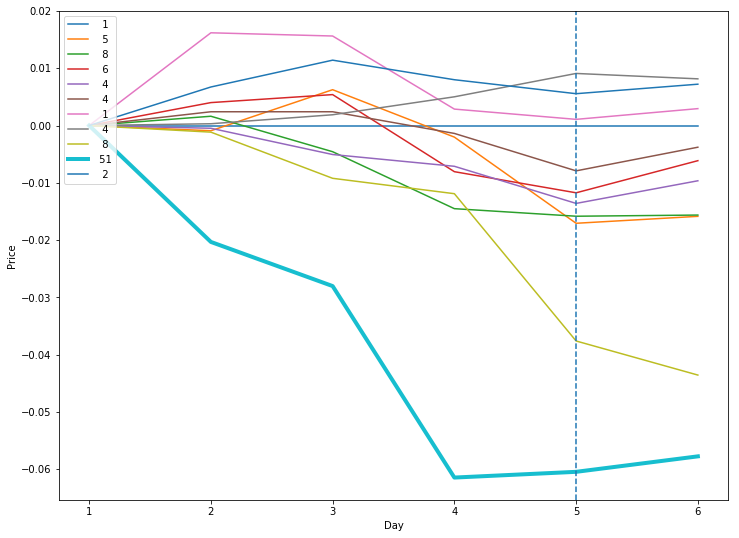

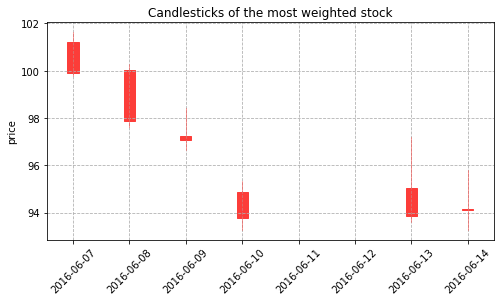

In [8]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num
import talib
from talib import abstract

idx = pd.IndexSlice
np.set_printoptions(precision=2, suppress=True, floatmode='fixed')



def candle(quotes, title):
    '''plot candlesticks'''
    fig, ax = plt.subplots(figsize=(8, 4))
    candlestick_ohlc(ax, quotes, colorup='#3cc35d', colordown='#fc3d39')
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.set_ylabel('price')
    ax.set_title(title)
    ax.grid(True, linestyle='--')
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(45)

def pattern(X):
    '''find out what pattern it is'''
    find = False
    X = X.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close'})
    for name in talib.get_function_groups()['Pattern Recognition']:
        f = abstract.Function(name)
        output = f(X)
        if np.any(output):
            find = True
            print('='*20)
            print(name)
            print(output[output!=0])
    if not find:
        print('No pattern found!')

def case(save_dir, k=0):
    # find extreme examples
    top = test_summary.sort_values(by='ret')
    display(top.head(10))
    index = top.index[k]

    # predict
    output = test_output.loc[index].values
    stock_idx = output.argmax()

    # print
    begin = index-data.window
    end = index+1
    X = data._historical_period(begin, end) # 3d, including price on current day
    y = data._price_change(index, end)[0]
    c = data._fi('Close')[0]
    closing = X[c]
    print("historical closing price:\n{}".format(closing))
    print("price change:\n{}".format(y,0))
    print("network output:\n{}".format(output))

    # plot
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    df = pd.DataFrame(closing).T
    df.index += 1
    # df.plot(ax=ax3)
    # convert raw output to portfolio weights
    weights = allocate(output)
    for i, c in enumerate(df.columns):
        if i == stock_idx:
            ax.plot(df[c], label='{:3d}'.format(int(weights[i]*100)), linewidth=4.0)
        else:
            ax.plot(df[c], label='{:3d}'.format(int(weights[i]*100)))
    ax.axvline(df.index[-2], linestyle='--')
    ax.legend(loc='upper left')
    
    best_stock = data.assets[stock_idx]
    # access data_raw directly instead of using X in order to get date and raw price
    OHLC = data.data_raw.iloc[begin:end].loc[:,idx[['Open', 'High', 'Low', 'Close'], best_stock]]
    OHLC.columns = OHLC.columns.droplevel(1)
    OHLC.reset_index(inplace=True)
    OHLC.Date = date2num(OHLC.Date)
    candle(OHLC.values, title='Candlesticks of the most weighted stock')

    pattern(OHLC.iloc[:-1])

# restart the kernel after changing dir
save_dir = Path('exp/base')

os.environ['CONFIG_LOCAL_DIR'] = str(save_dir)
from config_global import data
from main import allocate
test_summary = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col='index')
test_output = pd.read_csv(save_dir.joinpath('test_output.csv'), index_col=0)
test_output.columns = data.assets

case(save_dir, 400)

CASH     0.042
AAPL     0.075
ADBE     0.088
AMZN     0.086
CMCSA    0.122
CSCO     0.074
GOOGL    0.076
INTC     0.095
MSFT     0.070
NFLX     0.196
PEP      0.076
dtype: float64

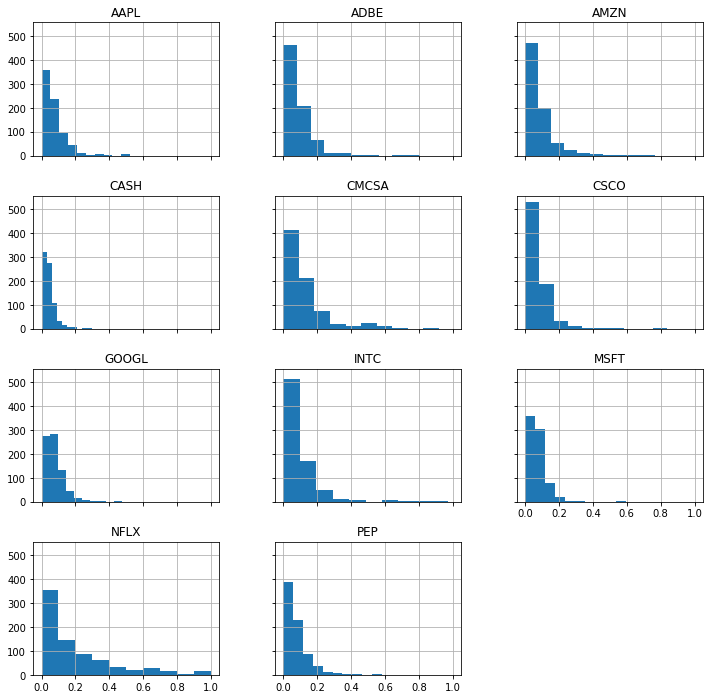

In [14]:
# raw output distribution
asset_num = test_output.shape[1]
# weight distribution of single asset
_ = test_output.hist(figsize=(min(asset_num*4, 12), (asset_num//3+1)*3), sharex=True, sharey=True)
# weight distribution of the whole backtest period
(test_output.sum(axis=0)/test_output.values.sum()).round(3)